# Dronninglund Pit Storage Measurement Data

This script describes the steps for quality control procedure of the operation data of the Dronninglund PTES for 2014. The original untreated data file is titled *Dronninglund_raw_data_2014.csv*, whereas the quality controlled file generated in this script is titled *Dronninglund_treated_data_2014.csv*.

First, import the necessary packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import requests

<br>

Read the raw CSV file containing the untreated data of the plant operation for 2014.

In [2]:
df_raw = pd.read_csv('Dronninglund_raw_data_2014.csv', index_col=[0], parse_dates=True)
# Set the time zone to be Danish standard time
df_raw.index = df_raw.index.tz_convert('Etc/GMT-1')
# Ensure a consistent time step of 10 minutes
df_raw = df_raw.asfreq('10min')
df_raw

,SO.DA.ET.422.5,SO.DA.HT.422.1.F,SO.DA.HT.422.1.T,SO.DA.HT.422.2.F,SO.DA.HT.422.2.T,SO.DA.LT.421,SO.DA.TT.401.01,SO.DA.TT.401.02,SO.DA.TT.401.03,SO.DA.TT.401.04,...,SO.TR.FT.472,SO.TR.MV.241.VS,SO.TR.MV.242.VS,SO.TR.PT.443,SO.TR.PT.444,SO.TR.TT.419,SO.TR.TT.420,SO.TR.TT.421,SO.TR.TT.430,SO.VP.TT.454
Tid,,,,,,,,,,,,,,,,,,,,,
2014-01-07 01:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07 01:10:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07 01:20:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07 01:30:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07 01:40:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:10:00+01:00,11.0,100.0,4.7,9.0,42.5,16.013,16.2,14.5,14.9,14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31 23:20:00+01:00,11.0,100.0,4.8,9.0,42.4,16.013,16.2,14.5,14.9,14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31 23:30:00+01:00,11.0,100.0,4.9,9.0,42.5,16.013,16.3,14.5,14.9,14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

Rename the storage temperature sensors using the format *T_{HH.H}*, where *HH.H* is the height of the temperature sensor relative to the bottom of storage. For example, the sensor mounted 1.5 m from the bottom is originally called "*SO.DA.TT.401.02*", and renamed to *T_01.5*.

In [3]:
# Get a list of the temperature sensors inside the storage (tags starting wtih 'SO.DA.TT.40')
water_sensor_original = [c for c in df_raw.columns if 'SO.DA.TT.40' in c]

water_sensor_unsorted = []  # Initialize list of new tags
for tag in water_sensor_original:
    primary_tag_number = int(tag.split('.')[-2])
    secondary_tag_number = int(tag.split('.')[-1])
    # Tags with a primary tag number of 401 are 0.5 m offset from those with 402
    if primary_tag_number == 401:
        offset = -0.5
    elif primary_tag_number == 402:
        offset = 0
    height = secondary_tag_number + offset
    # Format new tag names as T_HH.H
    water_sensor_unsorted.append('T_{:04.1f}'.format(height))

# Rename the sensors in the dataframe
water_sensor_dictionary = dict(zip(water_sensor_original, water_sensor_unsorted))
df_raw = df_raw.rename(columns=water_sensor_dictionary)

# Create a list of the sensors located inside the storage
water_sensors = sorted(water_sensor_unsorted)

<br>

Rename the ground temperature sensors using the format *Tg_HH*, where HH is the depth at which the ground temperature sensor is installed. For example, the sensor installed at 25 m below the embankment surfrace is named *Tg_25*.

In [4]:
ground_sensors_dictionary = {
    'SO.DA.TT.426.1': 'Tg_25',
    'SO.DA.TT.426.2': 'Tg_20',
    'SO.DA.TT.426.3': 'Tg_15',
    'SO.DA.TT.426.4': 'Tg_10'}

# Rename the ground sensors in the dataframe
df_raw = df_raw.rename(columns=ground_sensors_dictionary)

# Get list of sensors in the ground
ground_sensors = ground_sensors_dictionary.values()
ground_sensors_original = ground_sensors_dictionary.keys()

In [5]:
df_qc = df_raw.copy() # Create a new DataFrame for the quality controlled data

<br>

Removal of periods containing bad data from ground temperature sensors. These periods where determined by manual inspection of the data.

In [6]:
# Removal of periods with power outage and technical problems during the the start of the storage operation
df_qc.loc[:'2014-05-28 14', ['Tg_10', 'Tg_15', 'Tg_20']] = np.nan
df_qc.loc['2014-06-27 08':'2014-09-18', ['Tg_10', 'Tg_15', 'Tg_20']] = np.nan
df_qc.loc[:'2014-09-17', 'Tg_25'] = np.nan

# Temperature issues in May 2017
df_qc.loc['2017-05-01 16:30':'2017-05-01 19:30', ground_sensors] =np.nan # Three drops (spikes) in sensor values
df_qc.loc['2017-05-02':'2017-05-05', 'Tg_15'] = np.nan #  Strange dip in temperature
df_qc.loc['2017-05-02 13:30':'2017-05-02 16:30', 'Tg_20'] = np.nan #  Strange dip in temperature
df_qc.loc['2017-05-02 18:30':'2017-05-02 20:00', 'Tg_20'] = np.nan #  Strange dip in temperature
df_qc.loc['2017-05-03 08:30':'2017-05-03 09:30', 'Tg_20'] = np.nan #  Strange dip in temperature
df_qc.loc['2017-05-02':'2017-05-05', 'Tg_25'] = np.nan #  Strange dip in temperature, could be split in three

# Long-breakdowns
df_qc.loc['2016-05-01 20':'2020-06-18 11:30', 'Tg_10'] = np.nan #  Long breakdown of sensor
df_qc.loc['2017-05-15':'2020-06-22 08:00', 'Tg_15'] = np.nan #  Long breakdown of sensor, no clear start time, early date used
df_qc.loc['2019-06-25 08:30':'2020-06-18 11:00', 'Tg_20'] = np.nan # Long breakdown of sensor
df_qc.loc['2018-02-08 07:30':'2020-06-18 11:00', 'Tg_25'] = np.nan #  Long breakdown of sensor

# Short breakdowns
df_qc.loc['2017-03-09 20':'2017-03-10 07', ground_sensors] = np.nan #  all sensors drop to zero
df_qc.loc['2017-11-15 08':'2017-11-15 16', ['Tg_20','Tg_25']] = np.nan #  Temperature dropped to zero

<br>

Plot the original and the quailty controlled ground temperature data for visual inspection.

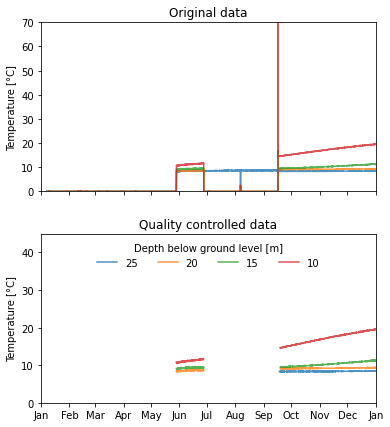

In [7]:
fig, axes = plt.subplots(nrows=2, figsize=(6,7), sharex=True)
axes[0].plot(df_raw[ground_sensors], alpha=0.8)
axes[1].plot(df_qc[ground_sensors], alpha=0.8)

axes[0].set_ylabel('Temperature [°C]')
axes[1].set_ylabel('Temperature [°C]')
axes[0].set_ylim(0,70)
axes[1].set_ylim(0,45)
axes[0].set_title('Original data')
axes[1].set_title('Quality controlled data')
axes[1].legend([25,20,15,10], title='Depth below ground level [m]', loc='upper center', ncol=4, frameon=False)

# Format x-ticks and set x-limits
axes[1].set_xticks(pd.date_range('2014-1-1', freq='MS', periods=13))
axes[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
axes[1].set_xlim(pd.Timestamp(2014,1,1), pd.Timestamp(2015,1,1))
axes[1].set_xlabel('')

fig.subplots_adjust(hspace=0.25)

<br>

In the following section periods with erroneous or questionable water temperature data have been removed from the dataset. Particularly, it can be noticed that there are periods where the temperature sensors were measuring either 0 °C or 120 °C, both of which are not feasible. These periods have been removed manually in the cell below. Additionally, periods whith very rapid temperature fluctuations occuring in only one layer were removed.

Furthermore, it was noticed that the top sensor (T_16.0) always has a higher temperature compared to the lower layers. However, during June to September 2014, it was measuring a lower temperature compared to the sensors immediate below it. Thus, this period was removed, as it was questionable whether it was correct or not. In general, the upper layers should always have a higher or equal temperature compared to the lower layers due to the lower density of water at higher temperature.

In [8]:
# Remove periods that have bad data for each sensor
df_qc.loc['2016-12-8 07':'2016-12-8 13', 'T_16.0'] = np.nan # Single small spike
df_qc.loc['2014-06-26': '2014-09-13', 'T_16.0'] = np.nan # The only period in the set where T_16 is lower thatn T_15.5
df_qc.loc[:'2014-01-31', 'T_16.0'] = np.nan # Remove initial temperature deviating from all the rest

df_qc.loc['2016-04-27':'2016-06-18', 'T_15.5'] = np.nan # Period of unreasonably low temperature
df_qc.loc['2016-12-08 06':'2016-12-08 13', 'T_15.5'] = np.nan # Single small spike
df_qc.loc['2014-06-27 08':'2014-06-27 22', 'T_15.5'] = np.nan # Period of zero temperature

df_qc.loc['2016-04-28':'2016-06-18', 'T_14.5'] = np.nan # Period of very "constant" low temperature

df_qc.loc['2015-11-18 10':'2015-11-18 14', 'T_14.0'] = np.nan # Single small spike downwards

df_qc.loc['2016-01-24':'2016-06-18', 'T_12.5'] = np.nan # Big period of bad measurements

df_qc.loc['2014-12-05':'2016-05-01', 'T_10.0'] = np.nan # Big period of bad measurements

df_qc.loc['2015-08-04':'2015-08-10', 'T_09.5'] = np.nan # Big period of bad measurements

df_qc.loc['2014-12-09 08':'2014-12-09 13', 'T_09.0'] = np.nan # Single small spike downwards

df_qc.loc['2015-10-05':'2016-05-01', 'T_08.0'] = np.nan # Big period of bad measurements

df_qc.loc['2015-09-23':'2016-05-01', 'T_07.0'] = np.nan # Big period of bad measurements
df_qc.loc['2015-02-14':'2015-02-25', 'T_07.0'] = np.nan # Big period of bad measurements
df_qc.loc['2015-07-13':'2015-07-16', 'T_07.0'] = np.nan # Big period of bad measurements
df_qc.loc['2015-08-14':'2015-08-19', 'T_07.0'] = np.nan # Big period of bad measurements
df_qc.loc['2015-08-30 05':'2015-08-30 13', 'T_07.0'] = np.nan # Spike downwards
df_qc.loc['2015-05-29':'2015-05-30', 'T_07.0'] = np.nan # Multiple small spikes downwards

df_qc.loc['2015-09-20':'2016-05-01', 'T_06.0'] = np.nan # Big period of bad measurements

df_qc.loc['2015-01-20':'2016-05-01', 'T_05.0'] = np.nan # Big period of bad measurements

df_qc.loc['2016-04-28 05':'2016-04-28 12', 'T_02.0'] = np.nan # Single small spike
df_qc.loc['2015-09-29':'2015-10-03', 'T_02.0'] = np.nan # Period with 120 degC
df_qc.loc['2015-12-01':'2016-03-15', 'T_02.0'] = np.nan # Period with low temperatures

df_qc.loc['2014-12-01':'2016-05-08', 'T_00.5'] = np.nan # Big period of bad measurements
df_qc.loc['2014-06-27 08':'2014-06-27 22', 'T_00.5'] = np.nan # Period with zero temperature


df_qc.loc['2016-04-28 05':'2016-04-28 12', ['T_16.0', 'T_15.0', 'T_14.0', 'T_13.0', 'T_12.0', 'T_11.0', 'T_09.0', 'T_04.0', 
                                          'T_03.0', 'T_01.0']] = np.nan # Single large spike

df_qc.loc['2014-06-27 10':'2014-06-27 14', ['T_16.0', 'T_15.0', 'T_14.0', 'T_13.0', 'T_12.0', 'T_11.0','T_10.5', 'T_09.5','T_07.5',
                                          'T_04.0']] = np.nan # Single small spike downwards

df_qc.loc['2014-06-27 15':'2014-06-27 20', ['T_10.5', 'T_09.5', 'T_07.5', 'T_04.0']] = np.nan # Single small spike downwards

df_qc.loc['2016-07-05':'2016-08-29', ['T_15.0','T_14.5']] = np.nan # Period of zero temperature for both sensors
        
df_qc.loc['2014-06-26':'2014-09-13', ['T_14.5', 'T_13.5', 'T_12.5', 'T_11.5', 'T_10.0', 'T_08.5', 'T_06.5', 'T_05.5', 'T_04.5',
                                    'T_03.5', 'T_03.0', 'T_02.5', 'T_02.0', 'T_01.0']] = np.nan # Period of zero temperature for many sensors
        
df_qc.loc['2016-04-27':'2016-06-18', ['T_13.5','T_11.5', 'T_10.5', 'T_09.5', 'T_08.5', 'T_07.5', 'T_06.5', 'T_05.5', 'T_04.5', 
                                    'T_03.5', 'T_02.5', 'T_01.5', 'T_00.5']] = np.nan # Period of zero temperature for many sensors

df_qc.loc['2016-11-07':'2016-12-10', ['T_02.0', 'T_01.5']] = np.nan # Big period of bad measurements

df_qc.loc['2014-06-27 05':'2014-06-28', ['T_04.0', 'T_01.5']] = np.nan # Small spike downwards

# Removals from all sensors
df_qc.loc[:'2014-01-21 16:30', water_sensors] = np.nan # Remove initial temperature of zero
df_qc.loc['2017-03-09 21':'2017-03-10 07', water_sensors] = np.nan # Temperature drops to zero
df_qc.loc['2017-05-01 16:30':'2017-05-01 19:30', water_sensors] = np.nan # Thress drops in temperature
df_qc.loc['2017-05-02 18:30':'2017-05-02 19', water_sensors] = np.nan # Temperature drops to zero
df_qc.loc['2017-05-02 18:30':'2017-05-02 19', water_sensors] = np.nan # Temperature drops to zero
df_qc.loc['2017-11-15 10':'2017-11-15 14:30', water_sensors] = np.nan # Temperature drops to zero
df_qc.loc['2017-05-02 13:30':'2017-05-02 15:00', water_sensors] = np.nan # Single time stamp dropped to zero 
df_qc.loc['2017-05-03 09:00':'2017-05-03 09:10', water_sensors] = np.nan # Single time stamp drops to zero
df_qc.loc['2017-05-04 12:00':'2017-05-04 13:00', water_sensors] = np.nan # Temperature drops to zero

<br>As a result of removing periods with erroneous or questionable data, a number of gaps in the time series of the water temperature were created. These gaps were filled by interpolation. A different interpolation method was used depending on the length of the gap. Periods of missing data shorter than 24 hours were linearly interpolated in time, which is resonable due to the slow time constant of the storage.

In [9]:
# Create a mask for interpolating only if data is missing within a day 
# (since the df has a freq=10 min, 144 cells that correspond to 24 hours)
mask = df_qc[water_sensors].copy()
grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
grp['ones'] = 1
for i in water_sensors:
    mask[i] = (grp.groupby(i)['ones'].transform('count') <= 144) | df_qc[i].notnull()

df_qc[water_sensors] = df_qc[water_sensors].interpolate().bfill()[mask]

<br> For long-term data-gaps (longer than 24 hours), the missing data was interpolated across the water layers. For example, if the temperature at 2.0 m was missing for one month, it was replaced by the average of the sensors at 1.5 m and 2.5 m.

In [10]:
df_qc[water_sensors] = df_qc[water_sensors].interpolate(axis=1, limit_direction='both')

<br> Plot the temperatures for each water layer in order to visualize the difference between the original data vs. the quality controlled and gap filled temperature data.

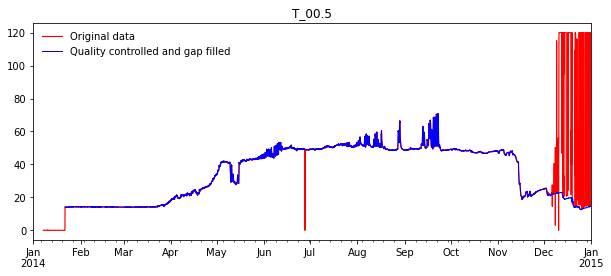

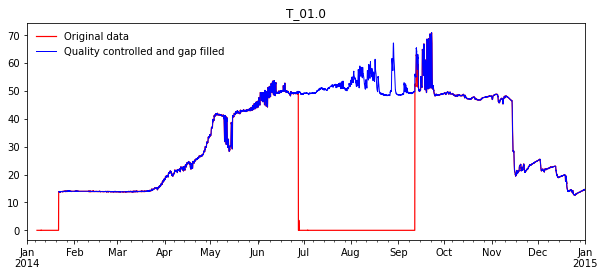

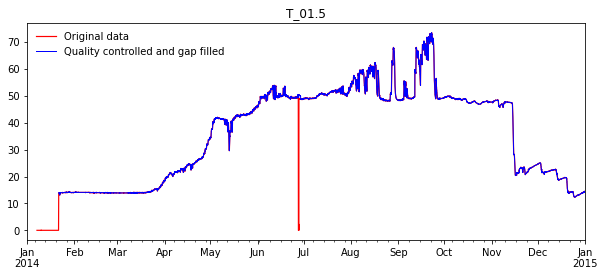

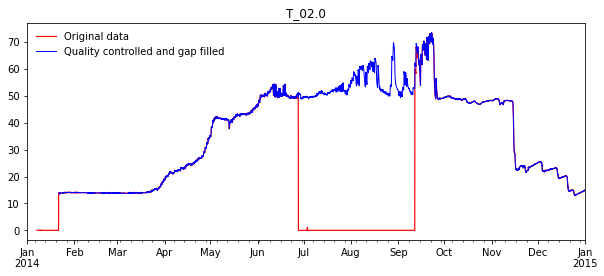

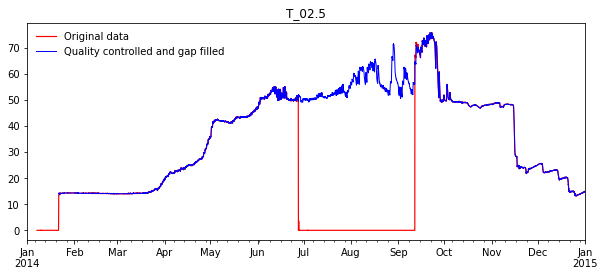

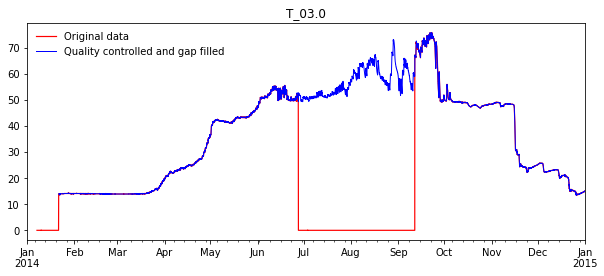

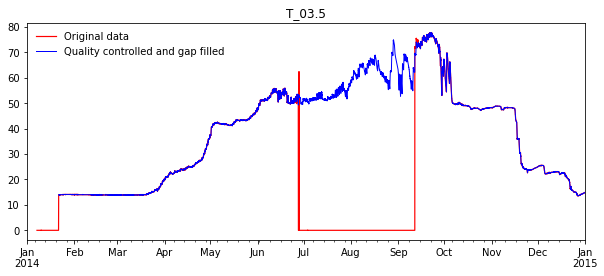

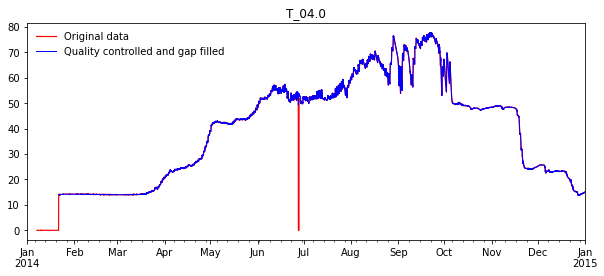

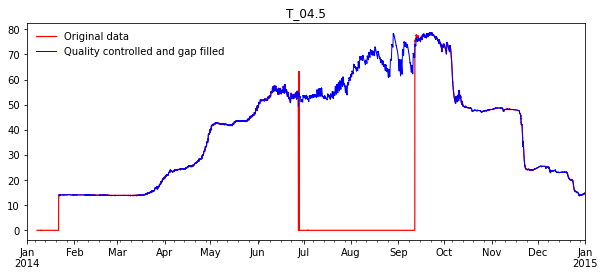

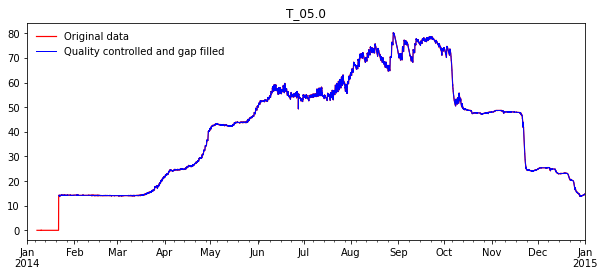

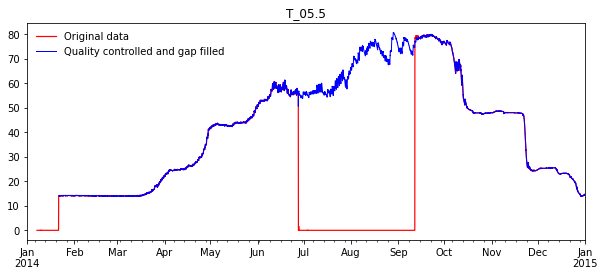

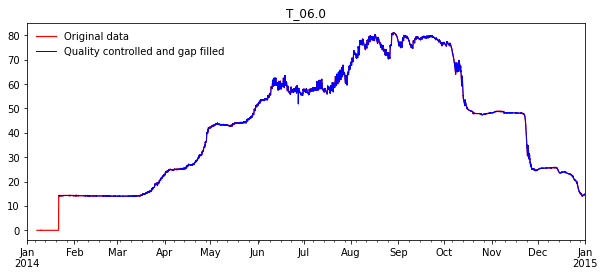

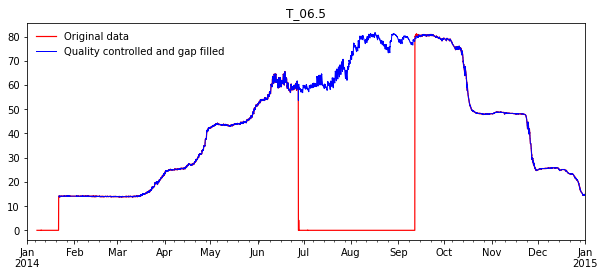

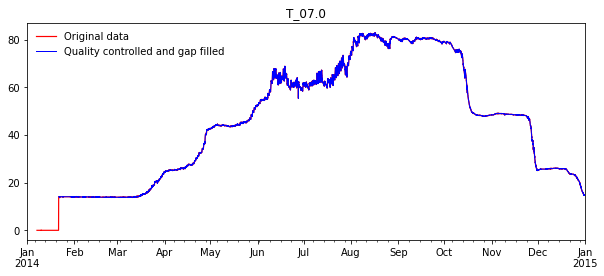

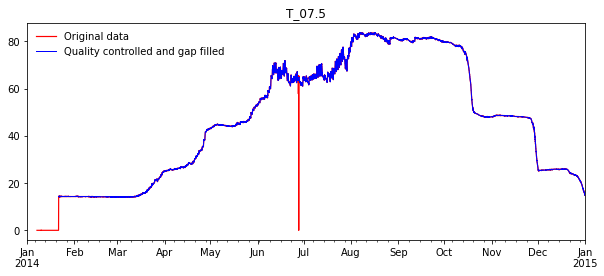

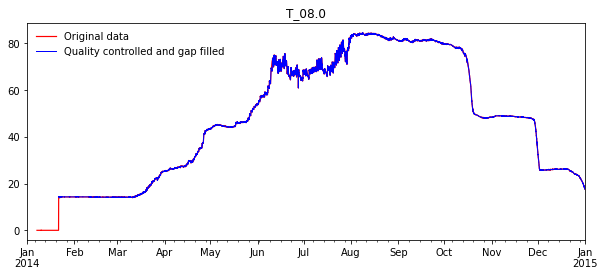

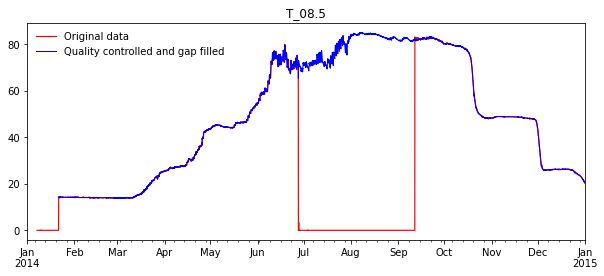

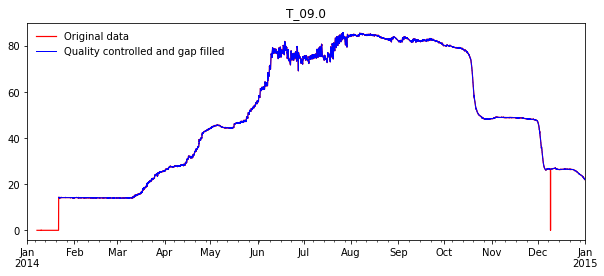

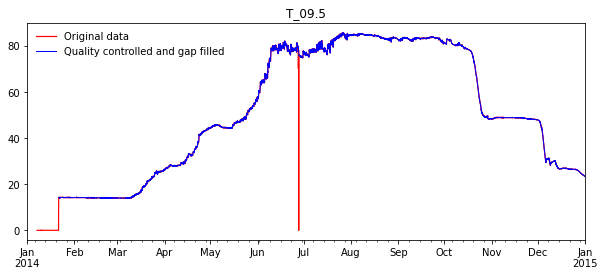

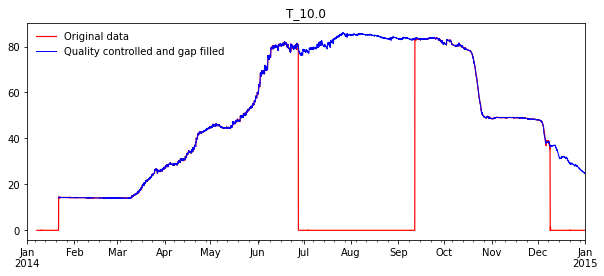

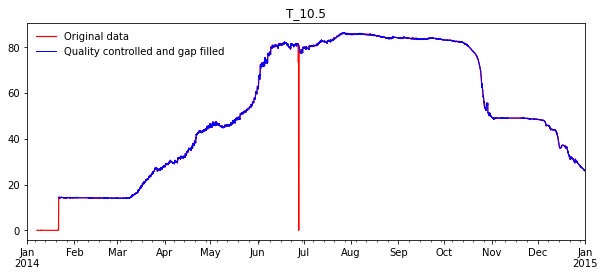

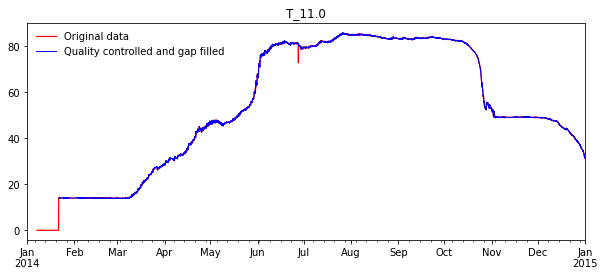

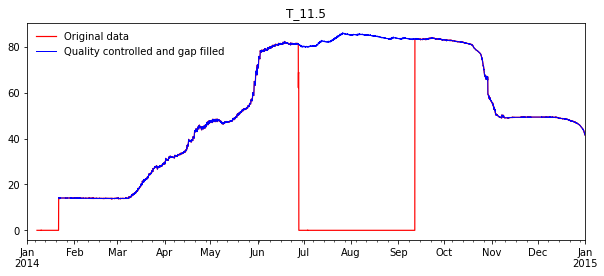

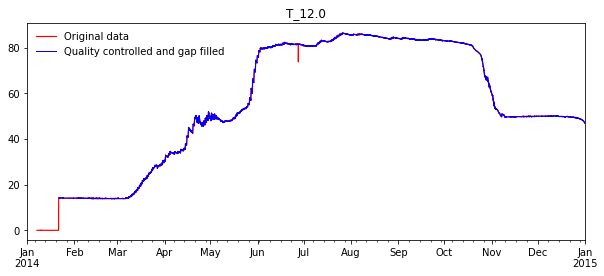

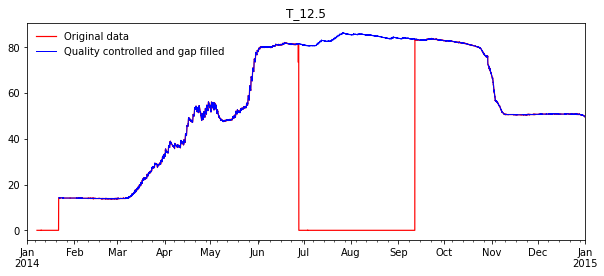

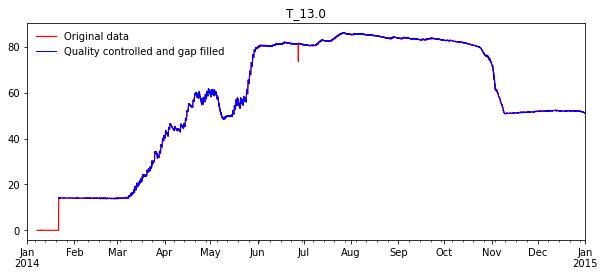

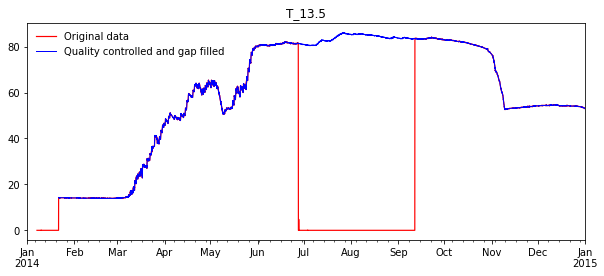

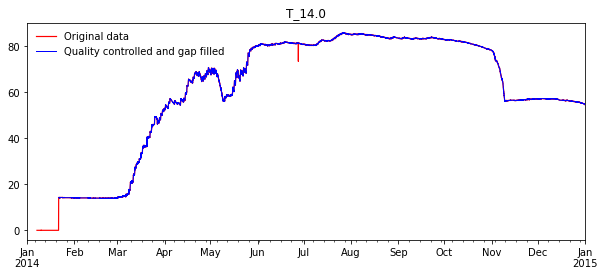

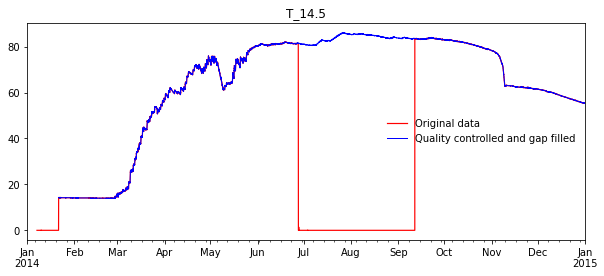

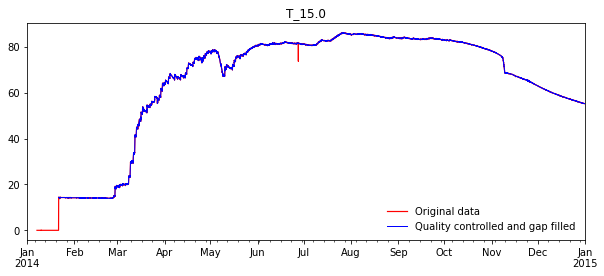

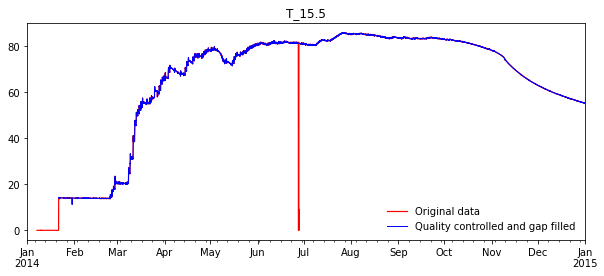

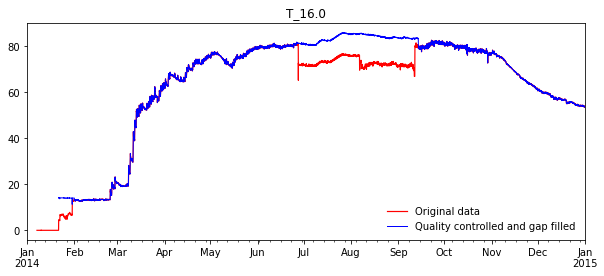

In [11]:
for sensor in water_sensors:
    plt.figure(figsize=(10,4))
    plt.title(sensor)
    df_raw[sensor].plot(c='r', lw=1.2, label='Original data')
    df_qc[sensor].plot(c='b', lw=1, label='Quality controlled and gap filled')
    plt.xlim(pd.Timestamp(2014,1,1), pd.Timestamp(2015,1,1))
    plt.xlabel('')
    plt.legend(frameon=False)
    plt.show()

<br> The following plot is a visualization of the interpolation across water layers.

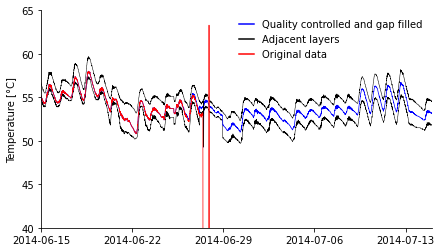

In [12]:
fig, axes = plt.subplots(figsize=(7,4))

axes.plot(df_qc['T_04.0'], c='k', lw=0.5, label='')
axes.plot(df_qc['T_04.5'], c='b', lw=0.7, label='Quality controlled and gap filled')

axes.plot(df_qc['T_05.0'], c='k', lw=0.5, label='Adjacent layers')
axes.plot(df_raw['T_04.5'], c='r', lw=0.7, label='Original data')

axes.set_xlabel('')
axes.set_ylabel('Temperature [°C]')
axes.set_ylim(40,65)

# Set legend parameters
legend= axes.legend(frameon=False, handlelength=1.5)
for legobj in legend.legendHandles:
    legobj.set_linewidth(1.5)

# Format x-ticks and set x-limits
axes.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
axes.set_xticks(pd.date_range(start='2014-6-15', end='2014-7-15', freq='1w'))
axes.set_xlim(pd.Timestamp(2014,6,15), pd.Timestamp(2014,7,15))

# Remove top and right figure borders
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

<br>

### Add data from DMI station

The ambient temperature measured at the storage is questionable, thus, the ambient temperature measured at a nearby weather station is added to the dataset. The station is Tylstrup (06031), which is operated by the Danish Meteorological Institute (DMI).

Ambient temperature is added to the dataset, which is named *"temp_dry"*. For a more detailed explanation the reader is reffered to https://predictablysunny.com/posts/dmi_data/.

In [13]:
# An API key to the DMI API can be obtained for free: https://confluence.govcloud.dk/display/FDAPI
api_key = 'redacted'  # substitute your own API key

# URL for the DMI API
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'

# Specify the desired start and end time
start_time = pd.Timestamp(2014, 1, 1)
end_time = pd.Timestamp(2014, 12, 31)

# Specify one or more station IDs or all_stations
stationIds = ['06031']
# Specify one or more parameter IDs or all_parameters
parameterIds = ['temp_dry']

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()

dfs = []
for station in stationIds:
    for parameter in parameterIds:
        # Specify query parameters
        params = {
            'api-key' : api_key,
            'datetime' : datetime_str,
            'stationId' : station,
            'parameterId' : parameter,
            'limit' : '300000',  # max limit
        }

        # Submit GET request with url and parameters
        r = requests.get(DMI_URL, params=params)
        # Extract JSON object
        json = r.json() # Extract JSON object
        # Convert JSON object to a MultiIndex DataFrame and add to list
        dfi = pd.json_normalize(json['features'])
        if dfi.empty is False:
            dfi['time'] = pd.to_datetime(dfi['properties.observed'])
            dfi[['station', 'parameter']] = station, parameter
            dfi = dfi.set_index(['parameter', 'station', 'time'])
            dfi = dfi['properties.value'].unstack(['station','parameter'])
            dfs.append(dfi)

df_dmi = pd.concat(dfs, axis='columns').sort_index()
# Convert the index in order to have the same format as the main dataframe
df_dmi.index = df_dmi.index.tz_convert('Etc/GMT-1')
df_dmi.head()

station,06031
parameter,temp_dry
time,
2014-01-01 01:00:00+01:00,4.2
2014-01-01 01:10:00+01:00,4.2
2014-01-01 01:20:00+01:00,4.1
2014-01-01 01:30:00+01:00,4.1
2014-01-01 01:40:00+01:00,4.0


Merge the DMI dataframe with the rest of the data, and set the frequency of the new dataframe to 10 minutes.

In [14]:
dff = pd.concat([df_qc, df_dmi], axis='columns')
dff = dff.sort_index()
dff = dff.asfreq('10min')
dff = dff.rename(columns={('06031', 'temp_dry'):'temp_dry'})

dff.describe()

,SO.DA.ET.422.5,SO.DA.HT.422.1.F,SO.DA.HT.422.1.T,SO.DA.HT.422.2.F,SO.DA.HT.422.2.T,SO.DA.LT.421,T_00.5,T_01.5,T_02.5,T_03.5,...,SO.TR.MV.241.VS,SO.TR.MV.242.VS,SO.TR.PT.443,SO.TR.PT.444,SO.TR.TT.419,SO.TR.TT.420,SO.TR.TT.421,SO.TR.TT.430,SO.VP.TT.454,temp_dry
count,51524.000000,51524.000000,51524.000000,51524.000000,51524.000000,8780.000000,49580.000000,49580.000000,49580.000000,49580.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51795.000000
mean,-69.599604,57.520321,5.520134,36.531733,59.149070,15.883145,35.483697,36.562426,38.163088,39.713477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.878525
std,391.438597,45.294532,20.035444,37.286179,26.710628,0.108528,15.781920,16.851604,17.882587,19.231881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.427853
min,-2000.000000,0.000000,-20.000000,0.000000,-20.000000,15.800000,12.500000,12.300000,13.200000,13.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.900000
25%,8.000000,0.000000,-20.000000,5.000000,46.800000,15.800000,19.300000,19.400000,20.200000,22.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
50%,11.000000,82.000000,5.700000,15.000000,72.700000,15.800000,43.100000,43.400000,44.200000,45.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.700000
75%,12.000000,100.000000,16.900000,74.000000,77.600000,16.023000,49.300000,49.400000,51.420000,53.260000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.500000
max,17.000000,100.000000,61.800000,100.000000,83.700000,16.057000,70.900000,73.500000,75.700000,77.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.000000


<br> 

Save the dataframe with the treated data to .csv format.

In [15]:
dff.to_csv('Dronninglund_treated_data_2014.csv')